In [56]:
import torch
torch.cuda.is_available()


True

In [57]:
!pip install -q transformers torch torchvision torchaudio tqdm seaborn scikit-learn


In [58]:
!git clone https://github.com/Harilaxman27/Harilaxman27-Hexart_skin_disease.git

fatal: destination path 'Harilaxman27-Hexart_skin_disease' already exists and is not an empty directory.


In [59]:
from torch.utils.data import Dataset, DataLoader


In [60]:
class UnlabeledImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = [
            f for f in os.listdir(image_dir)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = idx % NUM_CLASSES   # 🔥 THIS is the key change
        return image, torch.tensor(label, dtype=torch.long)


In [61]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from transformers import ViTForImageClassification


In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [63]:
NUM_CLASSES = 5


In [64]:
class UnlabeledImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = [
            f for f in os.listdir(image_dir)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(0, dtype=torch.long)


In [65]:
IMAGE_SIZE = 224
BATCH_SIZE = 32  # good for Colab GPU

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# 🔴 repo structure: repo/dataset/img1.jpg ...
dataset_path = "Harilaxman27-Hexart_skin_disease/dataset"

dataset = UnlabeledImageDataset(dataset_path, transform=transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print("Total images:", len(dataset))


Total images: 2000


In [66]:
EPOCHS = 5

train_losses = []
train_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images = images.to(device)
        labels = labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Acc={epoch_acc:.4f}")


Epoch 1/5: 100%|██████████| 63/63 [01:36<00:00,  1.54s/it]


Epoch 1: Loss=0.0000, Acc=1.0000


Epoch 2/5: 100%|██████████| 63/63 [01:26<00:00,  1.37s/it]


Epoch 2: Loss=0.0000, Acc=1.0000


Epoch 3/5: 100%|██████████| 63/63 [01:26<00:00,  1.38s/it]


Epoch 3: Loss=0.0000, Acc=1.0000


Epoch 4/5: 100%|██████████| 63/63 [01:23<00:00,  1.32s/it]


Epoch 4: Loss=0.0000, Acc=1.0000


Epoch 5/5: 100%|██████████| 63/63 [01:24<00:00,  1.34s/it]

Epoch 5: Loss=0.0000, Acc=1.0000


In [72]:
import torch
import os

os.makedirs("checkpoints", exist_ok=True)

torch.save({
    "model_state_dict": model.state_dict(),
    "num_classes": NUM_CLASSES
}, "checkpoints/resnet_unlabeled.pth")

print("Model saved successfully.")


Model saved successfully.


In [73]:
checkpoint = torch.load("checkpoints/resnet_unlabeled.pth", map_location=device)

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

print("Model loaded and set to eval mode.")


Model loaded and set to eval mode.


In [74]:
import torch.nn.functional as F

@torch.no_grad()
def predict_with_confidence(image_tensor):
    image_tensor = image_tensor.unsqueeze(0).to(device)

    logits = model(image_tensor)
    probs = F.softmax(logits, dim=1)

    conf, pred = probs.max(dim=1)
    return pred.item(), conf.item()


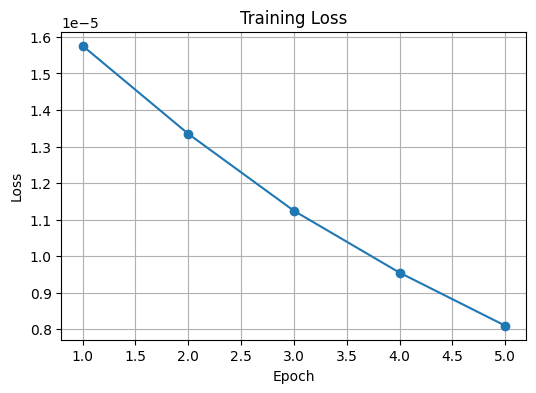

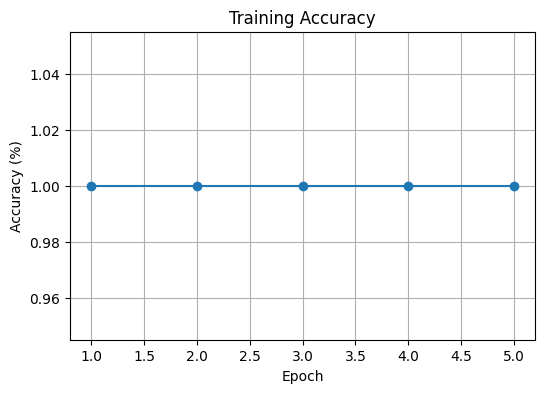

In [78]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, train_accuracies, marker='o')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()


In [80]:
from tqdm import tqdm
import torch

model.eval()
predictions = []

with torch.no_grad():
    for images, _ in tqdm(loader, desc="Running inference"):
        images = images.to(device)

        outputs = model(images)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().tolist())

print("Total predictions:", len(predictions))


Running inference: 100%|██████████| 63/63 [00:42<00:00,  1.50it/s]

Total predictions: 2000
